In [1]:
from model.model import build_model
from data.process import *
import keras

2024-07-08 08:18:14.001696: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 08:18:14.010065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 08:18:14.022408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 08:18:14.022438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 08:18:14.032379: I tensorflow/core/platform/cpu_feature_gua

In [2]:
train_df, dev_df, test_df = retrieve_train_dev_test_dataframe()


In [3]:

X_train, Y_train = split_input_output(train_df)
print(X_train.shape)
print(Y_train.shape)

(11389751, 11)
(11389751,)


In [4]:
X_dev, Y_dev = split_input_output(dev_df)
print(X_dev.shape)
print(Y_dev.shape)

(115047, 11)
(115047,)


In [5]:
train_dataset = convert_to_tensorflow_dataset(X_train, Y_train, 128)
dev_dataset = convert_to_tensorflow_dataset(X_dev, Y_dev, 128)

2024-07-08 08:18:26.316813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 08:18:26.418024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 08:18:26.418063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 08:18:26.420559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-08 08:18:26.420586: I external/local_xla/xla/stream_executor

In [6]:
model = build_model(len(X_train.columns), 64, 1)
opt = keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:

from model.model import checkpoint
history = model.fit(
    train_dataset, 
    epochs=10, 
    batch_size=64, 
    verbose=1, 
    validation_data=dev_dataset, 
    callbacks=[checkpoint]
)

Epoch 1/10


I0000 00:00:1720394318.144021   14219 service.cc:145] XLA service 0x7f9ab4027c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720394318.144067   14219 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-07-08 08:18:38.242001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 08:18:38.617379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   14/88983 ━━━━━━━━━━━━━━━━━━━━ 18:21 12ms/step - accuracy: 0.5498 - loss: 5.9095

I0000 00:00:1720394328.174910   14219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88983/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8764 - loss: 1.9901
Epoch 1: saving model to checkpoint/model-01-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 280s 3ms/step - accuracy: 0.8764 - loss: 1.9901 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 2/10
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 1.9821
Epoch 2: saving model to checkpoint/model-02-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 261s 3ms/step - accuracy: 0.8770 - loss: 1.9821 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 3/10


2024-07-08 08:27:38.790703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10694945 of 11389751


   12/88983 ━━━━━━━━━━━━━━━━━━━━ 21:39 15ms/step - accuracy: 0.8523 - loss: 2.3811

2024-07-08 08:27:39.424646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88982/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 1.9823
Epoch 3: saving model to checkpoint/model-03-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 277s 3ms/step - accuracy: 0.8770 - loss: 1.9823 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 4/10


2024-07-08 08:32:16.122980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10222147 of 11389751


   17/88983 ━━━━━━━━━━━━━━━━━━━━ 14:41 10ms/step - accuracy: 0.8825 - loss: 1.8941

2024-07-08 08:32:17.225521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88976/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8768 - loss: 1.9852
Epoch 4: saving model to checkpoint/model-04-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 264s 3ms/step - accuracy: 0.8768 - loss: 1.9852 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 5/10


2024-07-08 08:36:40.445522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10505478 of 11389751


   88/88983 ━━━━━━━━━━━━━━━━━━━━ 2:35 2ms/step - accuracy: 0.8788 - loss: 1.9541 

2024-07-08 08:36:41.407906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88981/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 1.9843
Epoch 5: saving model to checkpoint/model-05-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 274s 3ms/step - accuracy: 0.8769 - loss: 1.9843 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 6/10


2024-07-08 08:41:13.974546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10641537 of 11389751


   17/88983 ━━━━━━━━━━━━━━━━━━━━ 16:05 11ms/step - accuracy: 0.8792 - loss: 1.9470

2024-07-08 08:41:14.732688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88983/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - loss: 1.9811
Epoch 6: saving model to checkpoint/model-06-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 258s 3ms/step - accuracy: 0.8771 - loss: 1.9811 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 7/10


2024-07-08 08:45:31.899440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10745014 of 11389751


   24/88983 ━━━━━━━━━━━━━━━━━━━━ 10:01 7ms/step - accuracy: 0.8844 - loss: 1.8626  

2024-07-08 08:45:32.542102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88980/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 1.9847
Epoch 7: saving model to checkpoint/model-07-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 305s 3ms/step - accuracy: 0.8769 - loss: 1.9847 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 8/10


2024-07-08 08:50:37.036516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10607334 of 11389751


   25/88983 ━━━━━━━━━━━━━━━━━━━━ 9:42 7ms/step - accuracy: 0.8822 - loss: 1.8987 

2024-07-08 08:50:37.817882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88979/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 1.9838
Epoch 8: saving model to checkpoint/model-08-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 249s 3ms/step - accuracy: 0.8769 - loss: 1.9838 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 9/10


2024-07-08 08:54:45.953185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10674526 of 11389751


   15/88983 ━━━━━━━━━━━━━━━━━━━━ 19:15 13ms/step - accuracy: 0.8951 - loss: 1.6911

2024-07-08 08:54:47.004926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88982/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - loss: 1.9817
Epoch 9: saving model to checkpoint/model-09-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 268s 3ms/step - accuracy: 0.8771 - loss: 1.9817 - val_accuracy: 0.8785 - val_loss: 1.9589
Epoch 10/10


2024-07-08 08:59:13.906314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1: Filling up shuffle buffer (this may take a while): 10472670 of 11389751


   16/88983 ━━━━━━━━━━━━━━━━━━━━ 16:40 11ms/step - accuracy: 0.8973 - loss: 1.6555

2024-07-08 08:59:14.857514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


88980/88983 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - loss: 1.9814
Epoch 10: saving model to checkpoint/model-10-1.96.keras
88983/88983 ━━━━━━━━━━━━━━━━━━━━ 258s 3ms/step - accuracy: 0.8771 - loss: 1.9814 - val_accuracy: 0.8785 - val_loss: 1.9589


In [8]:
history.history

{'accuracy': [0.8769176006317139,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488,
  0.8769879341125488],
 'loss': [1.9838262796401978,
  1.9830001592636108,
  1.9830043315887451,
  1.9830138683319092,
  1.9829964637756348,
  1.983001708984375,
  1.9830089807510376,
  1.9830023050308228,
  1.9830135107040405,
  1.9830060005187988],
 'val_accuracy': [0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949,
  0.8784670829772949],
 'val_loss': [1.9588773250579834,
  1.9588779211044312,
  1.9588769674301147,
  1.958878993988037,
  1.9588783979415894,
  1.958878993988037,
  1.958878517150879,
  1.958876371383667,
  1.9588780403137207,
  1.9588779211044312]}

/tmp/ipykernel_13977/973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_13977/973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

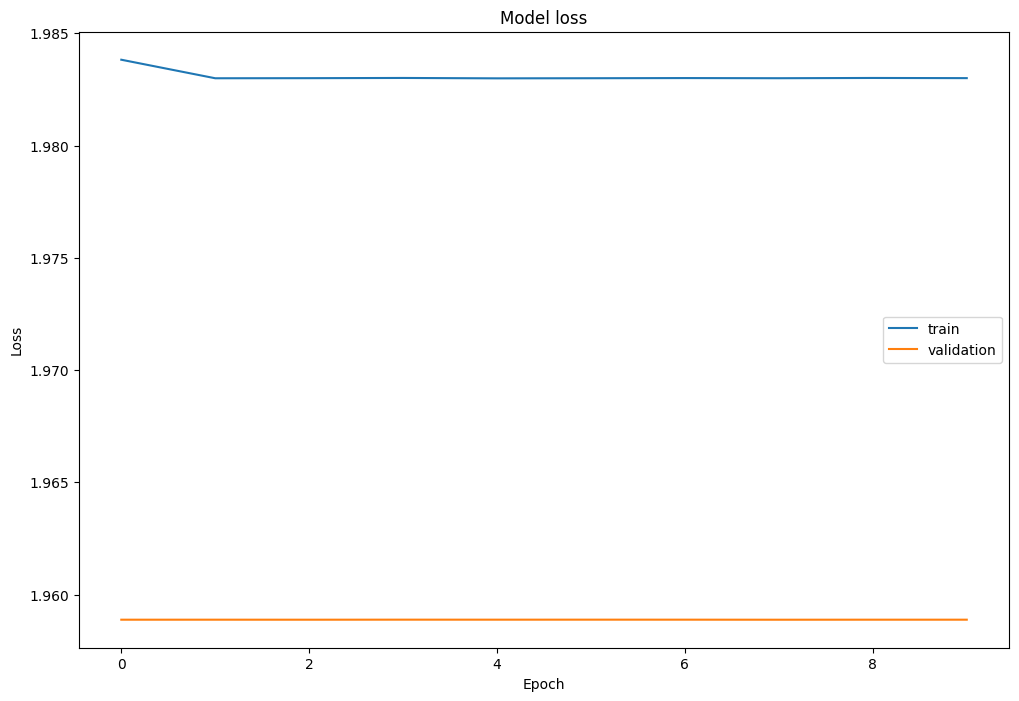

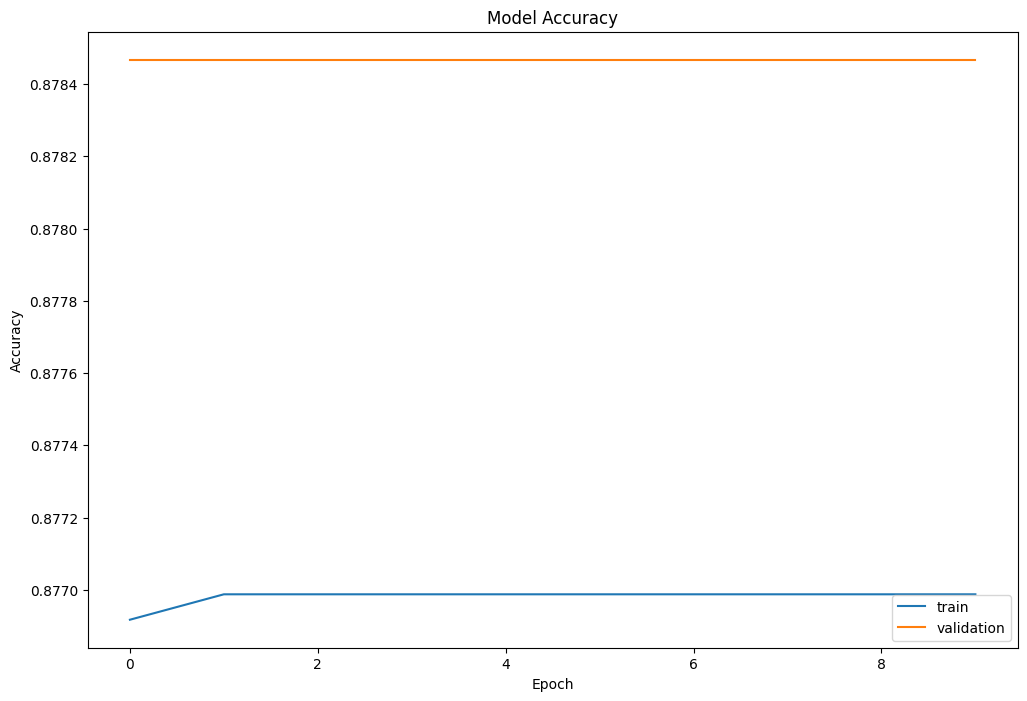

In [9]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')